In [1]:
# README:
# This notebook compares and XESMF regridding to an NCTools fregrid regridding. It is 
# intended to serve as an example of how one might use xESMF to do some NCTools compatible
# regridding. It also tries to make a qualitiative and graphical comparisons of the results. 
# NCTools apps are not run here, instead the output files of make_hgrid and fregrid
# are read in.
# This notebook is similar to the esmpy_vs_nctools_cr notebook in goal.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe



In [3]:
#The source grid is a regular lat-lon grid
# This is initially and NCT (NCTools) grid; from make_hgrid
grid_s = xr.open_dataset("/home/mzuniga/xesmf_misc/nct/R180x360_grid.nc")
grid_s

<xarray.Dataset>
Dimensions:   (nyp: 181, nxp: 361, nx: 360, ny: 180)
Dimensions without coordinates: nyp, nxp, nx, ny
Data variables:
    tile      |S255 ...
    x         (nyp, nxp) float64 ...
    y         (nyp, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    area      (ny, nx) float64 ...
    angle_dx  (nyp, nxp) float64 ...
    arcx      |S255 ...
Attributes:
    grid_version:          0.2
    code_release_version:  2023.01
    git_hash:              dcbfc104e96d8e8e59cdd7696f6b0bc0807defff
    creationtime:          Sun Sep 24 22:18:25 2023
    hostname:              sanjuan
    history:               make_hgrid --grid_type regular_lonlat_grid --nxbnd...

In [4]:
#"Converting" formats: NCT grid to xESMF grid
#grid_s = grid_s.rename({"x":"lon", "y":"lat"})  #this alone is not enough:

#Suggestion from Rapahel D. work
grid_s['lon'] = xr.DataArray(grid_s['x'].values[1::2, 1::2].copy(), dims=('ny2','nx2'))
grid_s['lon_b'] = xr.DataArray(grid_s['x'].values[0::2,0::2].copy(), dims=('ny2p1','nx2p1'))
grid_s['lat'] = xr.DataArray(grid_s['y'].values[1::2,1::2].copy(), dims=('ny2','nx2'))
grid_s['lat_b'] = xr.DataArray(grid_s['y'].values[0::2,0::2].copy(), dims=('ny2p1','nx2p1'))
grid_s['area2'] = xr.DataArray(grid_s['area'].values[1::2,1::2].copy(), dims=('ny2','nx2'))
grid_s


<xarray.Dataset>
Dimensions:   (nyp: 181, nxp: 361, nx: 360, ny: 180, ny2: 90, nx2: 180,
               ny2p1: 91, nx2p1: 181)
Dimensions without coordinates: nyp, nxp, nx, ny, ny2, nx2, ny2p1, nx2p1
Data variables: (12/13)
    tile      |S255 ...
    x         (nyp, nxp) float64 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
    y         (nyp, nxp) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    area      (ny, nx) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    ...        ...
    arcx      |S255 ...
    lon       (ny2, nx2) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
    lon_b     (ny2p1, nx2p1) float64 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0 360.0
    lat       (ny2, nx2) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lat_b     (ny2p1, nx2p1) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    area2     (ny2, nx2) float64 3.237e+08 3.237e+08 ... 1.079e+08 1.079e+08
Attributes:
    grid_version:          0.2
    code_release_version:  2023.01
    git_hash:              dcbfc104e96d8e8e59cdd7696f6b0bc0807defff
    creationtime:          Sun Sep 24 22:18:25 2023
    hostname:              sanjuan
    history:               make_hgrid --grid_type regular_lonlat_grid --nxbnd...

In [5]:
print(np.shape(grid_s.lon))

(90, 180)


In [6]:
print(grid_s.lon)

<xarray.DataArray 'lon' (ny2: 90, nx2: 180)>
array([[  1.,   3.,   5., ..., 355., 357., 359.],
       [  1.,   3.,   5., ..., 355., 357., 359.],
       [  1.,   3.,   5., ..., 355., 357., 359.],
       ...,
       [  1.,   3.,   5., ..., 355., 357., 359.],
       [  1.,   3.,   5., ..., 355., 357., 359.],
       [  1.,   3.,   5., ..., 355., 357., 359.]])
Dimensions without coordinates: ny2, nx2


In [7]:
print(grid_s.lat)

<xarray.DataArray 'lat' (ny2: 90, nx2: 180)>
array([[-89., -89., -89., ..., -89., -89., -89.],
       [-87., -87., -87., ..., -87., -87., -87.],
       [-85., -85., -85., ..., -85., -85., -85.],
       ...,
       [ 85.,  85.,  85., ...,  85.,  85.,  85.],
       [ 87.,  87.,  87., ...,  87.,  87.,  87.],
       [ 89.,  89.,  89., ...,  89.,  89.,  89.]])
Dimensions without coordinates: ny2, nx2


In [8]:
#The target grid, which also starts off as an NCT grid
# This grid of two degree resolution
grid_t = xr.open_dataset("/home/mzuniga/xesmf_misc/nct/R360x720_grid.nc")

In [9]:
# and also gets "converted" 
grid_t['lon'] = xr.DataArray(grid_t['x'].values[1::2, 1::2].copy(), dims=('ny2','nx2'))
grid_t['lon_b'] = xr.DataArray(grid_t['x'].values[0::2,0::2].copy(), dims=('ny2p1','nx2p1'))
grid_t['lat'] = xr.DataArray(grid_t['y'].values[1::2,1::2].copy(), dims=('ny2','nx2'))
grid_t['lat_b'] = xr.DataArray(grid_t['y'].values[0::2,0::2].copy(), dims=('ny2p1','nx2p1'))
grid_t['area2'] = xr.DataArray(grid_t['area'].values[1::2,1::2].copy(), dims=('ny2','nx2'))

In [10]:
 grid_t


<xarray.Dataset>
Dimensions:   (nyp: 361, nxp: 721, nx: 720, ny: 360, ny2: 180, nx2: 360,
               ny2p1: 181, nx2p1: 361)
Dimensions without coordinates: nyp, nxp, nx, ny, ny2, nx2, ny2p1, nx2p1
Data variables: (12/13)
    tile      |S255 ...
    x         (nyp, nxp) float64 0.0 0.5 1.0 1.5 2.0 ... 358.5 359.0 359.5 360.0
    y         (nyp, nxp) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    area      (ny, nx) float64 1.349e+07 1.349e+07 ... 1.349e+07 1.349e+07
    ...        ...
    arcx      |S255 ...
    lon       (ny2, nx2) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_b     (ny2p1, nx2p1) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0 360.0
    lat       (ny2, nx2) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lat_b     (ny2p1, nx2p1) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    area2     (ny2, nx2) float64 4.046e+07 4.046e+07 ... 1.349e+07 1.349e+07
Attributes:
    grid_version:          0.2
    code_release_version:  2023.01
    git_hash:              dcbfc104e96d8e8e59cdd7696f6b0bc0807defff
    creationtime:          Mon Nov 20 16:31:52 2023
    hostname:              sanjuan
    history:               make_hgrid --grid_type regular_lonlat_grid --nxbnd...

In [11]:
#A two degree resolution RLL grid, but made by an xESMF utility.
# By inspection, it seems equivalent to the converted grid_t above
grid_90 = xe.util.grid_global(d_lon=2, d_lat=2, lon1=360)
grid_90

<xarray.Dataset>
Dimensions:  (y: 90, x: 180, y_b: 91, x_b: 181)
Coordinates:
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon_b    (y_b, x_b) float64 0.0 2.0 4.0 6.0 8.0 ... 354.0 356.0 358.0 360.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [12]:
grid_180 = xe.util.grid_global(d_lon=1, d_lat=1, lon1=360)

In [13]:
#Regridder to map fron 2 deg to 1 deg
#You can use wither NCT generated grids or xESMF generated grids -  discrepancies will be the same
# regridder from 
#rg_90_180 = xe.Regridder(grid_90, grid_180, "conservative_normed")
rg_90_180 = xe.Regridder(grid_s, grid_t, "conservative_normed")

rg_90_180

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_90x180_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

In [14]:
#open a two degree dataset
#this is to be remapped to one degree
ds_s = xr.open_dataset("/home/mzuniga/nct_search/tests_xesmf/TestRR/R180x360.atmos_daily.nc")


In [15]:
ds_s

<xarray.Dataset>
Dimensions:       (grid_yt: 90, bnds: 2, grid_xt: 180, time: 8, pfull: 24)
Coordinates:
  * grid_yt       (grid_yt) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * grid_xt       (grid_xt) float32 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
  * time          (time) object 1980-01-01 12:00:00 ... 1980-01-08 12:00:00
  * pfull         (pfull) float32 3.65 19.09 52.34 99.13 ... 976.5 987.4 996.1
Dimensions without coordinates: bnds
Data variables:
    grid_yt_bnds  (grid_yt, bnds) float32 ...
    grid_xt_bnds  (grid_xt, bnds) float32 ...
    time_bounds   (time, bnds) timedelta64[ns] ...
    zsurf         (grid_yt, grid_xt) float32 ...
    temp          (time, pfull, grid_yt, grid_xt) float32 ...
    t_surf        (time, grid_yt, grid_xt) float32 ...
    average_T1    (time) datetime64[ns] ...
    average_T2    (time) datetime64[ns] ...
    average_DT    (time) timedelta64[ns] ...
Attributes:
    filename:              19800101.atmos_daily.tile1.nc
    title:                 c48_amip
    code_release_version:  2023.01
    git_hash:              dcbfc104e96d8e8e59cdd7696f6b0bc0807defff
    creationtime:          Mon Nov 13 17:44:07 2023
    hostname:              sanjuan
    history:               fregrid --input_mosaic R90x180_mosaic.nc --output_...

In [16]:
#RENAMING Coordiantes
#But this does not work:
#ds_s["lon"] = ds_s["grid_xt"]
#ds_s["lat"] = ds_s["grid_yt"]
#ds_s

ds_s = ds_s.rename({'grid_xt' : 'lon', 'grid_yt' : 'lat'})
ds_s 

<xarray.Dataset>
Dimensions:       (lat: 90, bnds: 2, lon: 180, time: 8, pfull: 24)
Coordinates:
  * lat           (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * time          (time) object 1980-01-01 12:00:00 ... 1980-01-08 12:00:00
  * pfull         (pfull) float32 3.65 19.09 52.34 99.13 ... 976.5 987.4 996.1
Dimensions without coordinates: bnds
Data variables:
    grid_yt_bnds  (lat, bnds) float32 ...
    grid_xt_bnds  (lon, bnds) float32 ...
    time_bounds   (time, bnds) timedelta64[ns] ...
    zsurf         (lat, lon) float32 ...
    temp          (time, pfull, lat, lon) float32 ...
    t_surf        (time, lat, lon) float32 ...
    average_T1    (time) datetime64[ns] ...
    average_T2    (time) datetime64[ns] ...
    average_DT    (time) timedelta64[ns] ...
Attributes:
    filename:              19800101.atmos_daily.tile1.nc
    title:                 c48_amip
    code_release_version:  2023.01
    git_hash:              dcbfc104e96d8e8e59cdd7696f6b0bc0807defff
    creationtime:          Mon Nov 13 17:44:07 2023
    hostname:              sanjuan
    history:               fregrid --input_mosaic R90x180_mosaic.nc --output_...

In [17]:
ds_s_temp = ds_s["temp"]
#temp is dour dimensional; select for one times and one pful
ds_s_temp = ds_s_temp [1][1]
ds_s_temp

<xarray.DataArray 'temp' (lat: 90, lon: 180)>
[16200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
    time     object 1980-01-02 12:00:00
    pfull    float32 19.09
Attributes:
    long_name:      temperature
    units:          K
    valid_range:    [100. 350.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order1

In [18]:
#Remap to 1 deg
ds_t_temp = rg_90_180 (ds_s_temp)
ds_t_temp

/home/mzuniga/miniconda3/envs/xesmf_env/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('lat', 'lon') from data variable temp as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (ny2: 180, nx2: 360)>
array([[216.4703 , 216.4703 , 216.4703 , ..., 216.46623, 216.46623,
        216.46623],
       [216.4703 , 216.4703 , 216.4703 , ..., 216.46623, 216.46623,
        216.46623],
       [216.4703 , 216.4703 , 216.4703 , ..., 216.46623, 216.46623,
        216.46623],
       ...,
       [213.65233, 213.65233, 213.65233, ..., 213.65479, 213.65479,
        213.65479],
       [213.65233, 213.65233, 213.65233, ..., 213.65479, 213.65479,
        213.65479],
       [213.65233, 213.65233, 213.65233, ..., 213.65479, 213.65479,
        213.65479]], dtype=float32)
Coordinates:
    time     object 1980-01-02 12:00:00
    pfull    float32 19.09
Dimensions without coordinates: ny2, nx2
Attributes:
    regrid_method:  conservative_normed

In [19]:
#The one degree dataset as remmapped by NCT
ds_t_nct = xr.open_dataset("/home/mzuniga/nct_search/tests_xesmf/TestRR/R360x720.atmos_daily.nc")
##temp is four dimentional. Select for one time and one pfull
ds_t_nct_temp = ds_t_nct.temp[1][1]
ds_t_nct_temp.values

array([[216.4703 , 216.4703 , 216.4703 , ..., 216.46623, 216.46623,
        216.46623],
       [216.4703 , 216.4703 , 216.4703 , ..., 216.46623, 216.46623,
        216.46623],
       [216.4703 , 216.4703 , 216.4703 , ..., 216.46623, 216.46623,
        216.46623],
       ...,
       [213.65233, 213.65233, 213.65233, ..., 213.65479, 213.65479,
        213.65479],
       [213.65233, 213.65233, 213.65233, ..., 213.65479, 213.65479,
        213.65479],
       [213.65233, 213.65233, 213.65233, ..., 213.65479, 213.65479,
        213.65479]], dtype=float32)

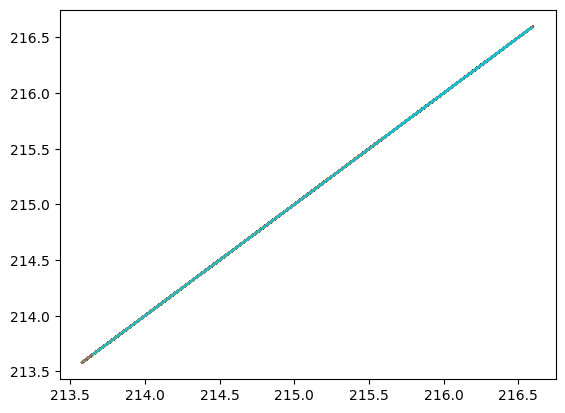

In [20]:
plt.plot(ds_t_temp.values, ds_t_nct_temp.values)
plt.show()


In [21]:
diff = ds_t_temp - ds_t_nct_temp.values
diff
#NOTE: Scaling by 100 for display purposes
diff = diff * 100

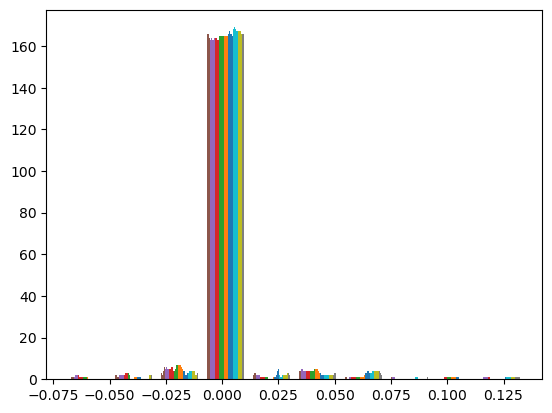

In [22]:
plt.hist(diff, 10)
plt.show()
#Note most discrepancies are within i part in ten thousand; some are not and up to about 1 part in a thousand

In [23]:
#Inspecting max error in the set index 

fdiff = diff.values.flatten()
me_idx  =  fdiff.argmax()
me_idx

50704

In [24]:
fd_v = fdiff [me_idx]


In [25]:
#Verify by printing the various componentrs
fd_v
#NOTE this below is really .00134 since data is scaled by 100 
# this is also about 6e-4 percent error ; error is inthe 6th significant digit

0.13427734

In [26]:
ds_t_temp.values.flatten()[me_idx]

214.9826

In [27]:
ds_t_nct_temp.values.flatten()[me_idx]

214.98126

In [28]:
#plot error magnitues with heat color map on sphere

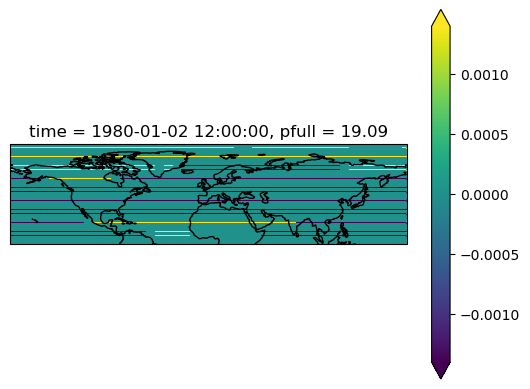

In [29]:
ax = plt.axes(projection=ccrs.PlateCarree())
diff.plot.pcolormesh(ax=ax, vmin=-.0014, vmax=.0014)
ax.coastlines()